In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import os 
import csv


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [12]:
#Trazendo os dados para o python
data = pd.read_excel('listings.xlsx')
df = data.loc[(data.state=='DC')&(data.city=='Washington')]


In [13]:
#Selecionando somente as colunas que queremos trabalhar com e tirando os sinais de moedas 
colunas = ["latitude", "longitude", "property_type","bathrooms", "bedrooms", "beds", "price","extra_people","minimum_nights", "review_scores_rating","cancellation_policy"]
df = df.loc[:,colunas]

df.price = df.price.str.replace('$', '')
df.price = df.price.str.replace(',', '')
df.extra_people = df.extra_people.str.replace('$', '')


df['price']=df['price'].astype(float)
df['extra_people']= df['extra_people'].astype(float)
df = df.dropna()



Correlacao: -0.11977850029420414
Correlacao: -0.13265110792733373
Correlacao: 0.5263197092853233
Correlacao: 0.6104477984168931
Correlacao: 0.566826558048037
Correlacao: 0.1633593478911218
Correlacao: 0.034239469945253315
Correlacao: 0.051161156394228885


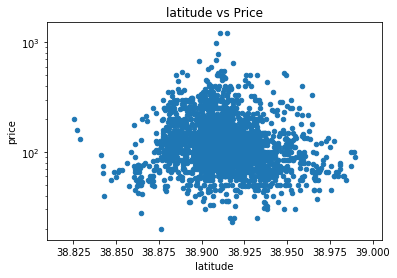

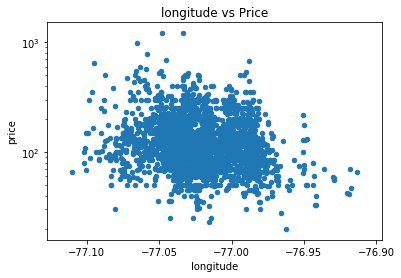

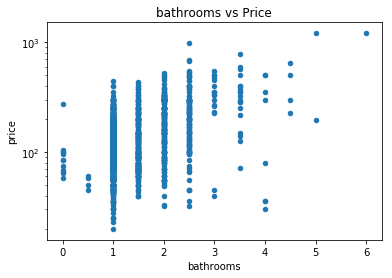

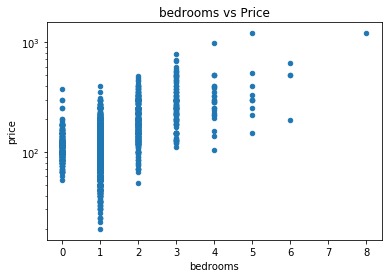

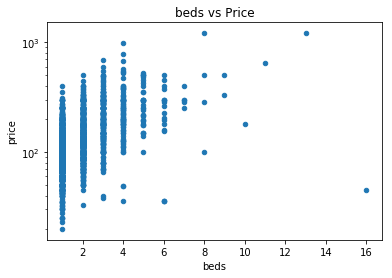

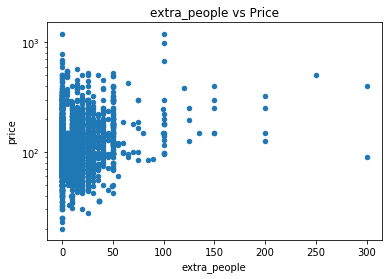

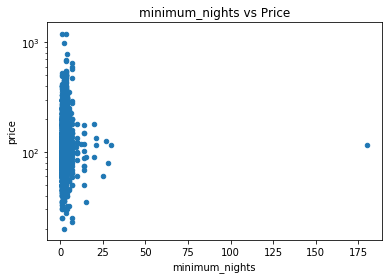

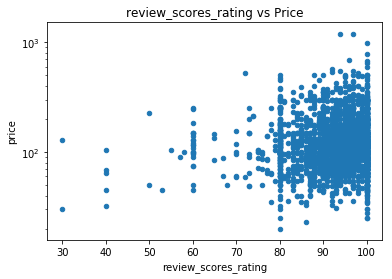

In [25]:
#criando uma funcao
colunas_quant= ["latitude", "longitude","bathrooms", "bedrooms", "beds","extra_people","minimum_nights", "review_scores_rating"]

def funcao_corr(lista):
    for x in colunas_quant:
        df_1 = df[['price', x]]
        print('Correlacao: {0}'.format(df.price.corr(df[x])))
        df_1.plot.scatter(x=x, y = 'price', logy=True)
        plt.title('{0} vs Price'.format(x))
        
        
funcao_corr(colunas_quant)
        
        

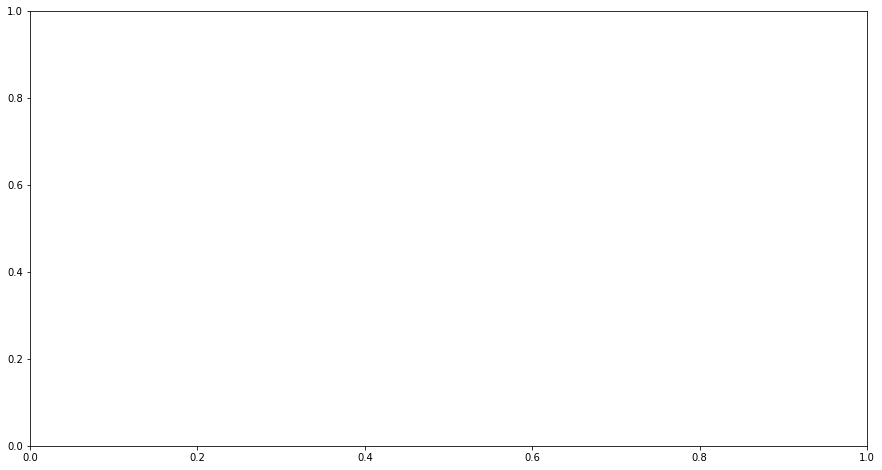

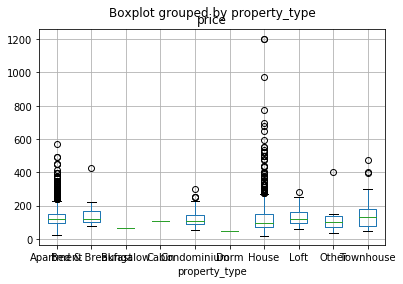

In [33]:
fig, pl = plt.subplots(figsize=(15,8));
df.boxplot(column=['price'], by='property_type');
